In [1]:
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import re
import cv2

In [2]:
def highpassFilter(input_image_path):
    img = cv2.imread(input_image_path, 1)
    
    rows, cols, c = img.shape
    crow, ccol = int(rows/2), int(cols/2) # 中心位置
    img = img[crow-32:crow+32,ccol-32:ccol+32]
    
    h, w, c = img.shape

    b, g, r = cv2.split(img)

    channels = [b, g ,r]

    for i in range(3):

        img_float32 = np.float32(channels[i])

        dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)

        rows, cols = img_float32.shape
        crow, ccol = int(rows/2), int(cols/2) # 中心位置

        # 高通滤波
        mask = np.ones((rows,cols,2),np.uint8)
        mask[crow-1:crow+1,ccol-1:ccol+1] = 0 # 中间区域置 0，外面的区域置 1

        # IDFT
        fshift = dft_shift * mask
        f_ishift = np.fft.ifftshift(fshift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(img_back[:,:,0], img_back[:, :, 1])
        channels[i] = np.uint8(img_back/h/w)
                                          

    img_back = cv2.merge(channels)
    img_back = cv2.cvtColor(img_back,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    '''
    删去此句可在plt.imshow()显示图片
    '''
    img_back = img_back.astype(np.float32)

    
    return img_back

In [3]:
'''
test
'''
# def highpassFilter(input_image_path):
#     img = cv2.imread(input_image_path, 1)
    
#     print(img.shape)
    
#     h, w, c = img.shape

#     b, g, r = cv2.split(img)

#     channels = [b, g ,r]

#     for i in range(3):

#         img_float32 = np.float32(channels[i])

#         dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
#         dft_shift = np.fft.fftshift(dft)

#         rows, cols = img_float32.shape
#         crow, ccol = int(rows/2), int(cols/2) # 中心位置

#         # 高通滤波
#         mask = np.ones((rows,cols,2),np.uint8)
#         mask[crow-20:crow+20,ccol-20:ccol+20] = 0 # 中间区域置 0，外面的区域置 1

#         # IDFT
#         fshift = dft_shift * mask
#         f_ishift = np.fft.ifftshift(fshift)
#         img_back = cv2.idft(f_ishift)
#         img_back = cv2.magnitude(img_back[:,:,0], img_back[:, :, 1])
#         channels[i] = np.uint8(img_back/h/w)
                                          

#     img_back = cv2.merge(channels)
#     img_back = cv2.cvtColor(img_back,cv2.COLOR_BGR2RGB)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# #     img_back = img_back.astype(np.float32)

    
#     return img_back

'\ntest\n'

In [4]:
'''
test
'''

# path = '../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/rain/norain-1001x2.png'
# img_o = cv2.imread(path)
# img = highpassFilter(path)

# rows, cols, c = img_o.shape
# crow, ccol = int(rows/2), int(cols/2) # 中心位置
# img_o = img_o[crow-32:crow+32,ccol-32:ccol+32]


# plt.subplot(121),plt.imshow(img_o)
# plt.title('Input Image'), plt.xticks([]),plt.yticks([])
# plt.subplot(122),plt.imshow(img)
# plt.title('Result'),plt.xticks([]),plt.yticks([])

# plt.plot()
# plt.imshow(img)

'\ntest\n'

In [5]:
'''
Dataset for Training.
'''
class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms1 = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
        self.transforms2 = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        '''
        Ensure input and label are in couple.
        '''
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        input_highpass_img = highpassFilter(input_image_path)
        
        
#         plt.subplot(121),plt.imshow(input_image)
#         plt.title('Input Image'), plt.xticks([]),plt.yticks([])
#         plt.subplot(122),plt.imshow(input_highpass_img)
#         plt.title('Result'),plt.xticks([]),plt.yticks([])
#         plt.waitforbuttonpress()
        
        input = self.transforms1(input_image)
        input_highpass_img = self.transforms2(input_highpass_img)
        label = self.transforms1(label_image)

        
        return input, input_highpass_img, label

'''
Dataset for testing.
'''
class MyValidDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms1 = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
        self.transforms2 = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        input_highpass_img = highpassFilter(input_image_path)
        
        input = self.transforms1(input_image)
        input_highpass_img = self.transforms2(input_highpass_img)
        label = self.transforms1(label_image)
        
        return input, input_highpass_img, label

In [6]:
# '''
# Residual_Network with BatchNormalized.
# '''
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv0 = nn.Sequential(
#             nn.Conv2d(6, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.res_conv1 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.res_conv2 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.res_conv3 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.res_conv4 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.res_conv5 = nn.Sequential(
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
        
#         self.conv = nn.Sequential(
#             nn.Conv2d(32, 3, 3, 1, 1),
#         )
        
#     def forward(self, input):
#         x = input
#         for i in range(6):  # Won't change the number of parameters
            
#             '''
#             Different from Classification.
#             '''
#             x = torch.cat((input, x), 1)
#             x = self.conv0(x)
#             x = F.relu(self.res_conv1(x) + x)
#             x = F.relu(self.res_conv2(x) + x)
#             x = F.relu(self.res_conv3(x) + x)
#             x = F.relu(self.res_conv4(x) + x)
#             x = F.relu(self.res_conv5(x) + x)
#             x = self.conv(x)
#             x = x + input
            
#         return x

In [7]:
class DDNet(nn.Module):
    def __init__(self):
        super(DDNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv9 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv10 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv11 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        
        self.conv12 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv13 = nn.Sequential(
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        self.conv14 = nn.Sequential(
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, input, input_highpass_image):
        '''
        Here get low Hz info
        '''
#       for img in x:
#           img_np = img.data.cpu().numpy()
#           img_tp = np.transpose(img_np, (1, 2, 0))
#           x_np = img_tp
#           plt.imshow(x_np)
#           x_np = np.transpose(x_np, (2, 0, 1))
#           x_np = torch.from_numpy(x_np)
#           x_np = x_np.to('cuda')
#           print(x_np.shape)
#           print(x_np.device)
#           print(x_np.is_cuda)
#       img_float32 = np.float32(img)

#       dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
#       dft_shift = np.fft.fftshift(dft)

#       rows, cols = img.shape
#       crow, ccol = int(rows/2), int(cols/2)

#       mask = np.zeros((rows, cols, 2), np.uint8)
#       mask[crow-30:crow+30, ccol-30:ccol+30] = 255

#      fshift = dft_shift*mask
#      f_ishift = np.fft.ifftshift(fshift)
#      img_back = cv2.idft(f_ishift)
#      img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

#         input_np = input.data.cpu().numpy()
#         print(input_np.shape[0])
#         while i<input_np.shape[0]:
#             input_np[i] = np.transpose(img_np[i], (1, 2, 0))
            
#             img_float = np.float32(input_np[i])
#             dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
#             dft_shift = np.fft.fftshift(dft)

#             rows, cols = img.shape
#             crow, ccol = int(rows/2), int(cols/2)

#             mask = np.zeros((rows, cols, 2), np.uint8)
#             mask[crow-30:crow+30, ccol-30:ccol+30] = 255

#             fshift = dft_shift*mask
#             f_ishift = np.fft.ifftshift(fshift)
#             img_back = cv2.idft(f_ishift)
#             img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
            
#             input_np[i] = 
        
        x = input
        
        xd = input_highpass_image
        
        
        x1 = self.conv1(xd)
        x2 = self.conv2(x1) + x1
        x3 = self.conv3(x2) + x2
        x4 = self.conv4(x3) + x3
        x5 = self.conv5(x4) + x4
        x6 = self.conv5(x5) + x5
        x7 = self.conv6(x6) + x6
        x8 = self.conv7(x7) + x7
        x9 = self.conv8(x8) + x8
        x10 = self.conv9(x9) + x9
        x11 = self.conv10(x10) +x10
        x12 = self.conv11(x11) + x11
        x13 = self.conv12(x12) + x12
        x14 = self.conv13(x13) + x13
        
        xout = self.conv14(x14) + x
        
        return xout
        

In [8]:
'''
Check the number of GPU.
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 2 GPUs!


Restart...


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 26.63945


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 3.79859
[ Valid | 001/500 ] loss = 3.79859 -> best
Best model found at epoch 1, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 24.64681


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 2.77121
[ Valid | 002/500 ] loss = 2.77121 -> best
Best model found at epoch 2, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 23.06684


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 1.98320
[ Valid | 003/500 ] loss = 1.98320 -> best
Best model found at epoch 3, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 21.56370


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 1.33146
[ Valid | 004/500 ] loss = 1.33146 -> best
Best model found at epoch 4, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 20.16978


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 4.21007
[ Valid | 005/500 ] loss = 4.21007


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 18.87205


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 3.50217
[ Valid | 006/500 ] loss = 3.50217


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 17.63410


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 1.00023
[ Valid | 007/500 ] loss = 1.00023 -> best
Best model found at epoch 7, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 16.43809


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 1.05768
[ Valid | 008/500 ] loss = 1.05768


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 15.35059


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 1.49160
[ Valid | 009/500 ] loss = 1.49160


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 14.27933


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 2.70193
[ Valid | 010/500 ] loss = 2.70193


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 13.23239


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 3.57098
[ Valid | 011/500 ] loss = 3.57098


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 12.29344


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 2.73157
[ Valid | 012/500 ] loss = 2.73157


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 11.44577


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 0.66304
[ Valid | 013/500 ] loss = 0.66304 -> best
Best model found at epoch 13, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 10.60187


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 0.44050
[ Valid | 014/500 ] loss = 0.44050 -> best
Best model found at epoch 14, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 9.80675


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 1.39631
[ Valid | 015/500 ] loss = 1.39631


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 9.04585


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 2.54814
[ Valid | 016/500 ] loss = 2.54814


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 8.34359


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 2.28890
[ Valid | 017/500 ] loss = 2.28890


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 7.68947


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 2.40270
[ Valid | 018/500 ] loss = 2.40270


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 7.09947


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 0.56612
[ Valid | 019/500 ] loss = 0.56612


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 6.51606


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 0.75627
[ Valid | 020/500 ] loss = 0.75627


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 5.96335


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 0.70794
[ Valid | 021/500 ] loss = 0.70794


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 5.45627


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 0.99550
[ Valid | 022/500 ] loss = 0.99550


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 5.00408


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 0.52043
[ Valid | 023/500 ] loss = 0.52043


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 4.56249


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 1.23127
[ Valid | 024/500 ] loss = 1.23127


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 4.16607


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 0.87344
[ Valid | 025/500 ] loss = 0.87344


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 3.78041


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 0.55951
[ Valid | 026/500 ] loss = 0.55951


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 3.44342


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 0.48833
[ Valid | 027/500 ] loss = 0.48833


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 3.12716


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 0.27949
[ Valid | 028/500 ] loss = 0.27949 -> best
Best model found at epoch 28, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 2.82668


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 0.60274
[ Valid | 029/500 ] loss = 0.60274


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 2.55266


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 0.80047
[ Valid | 030/500 ] loss = 0.80047


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 2.30416


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 0.46575
[ Valid | 031/500 ] loss = 0.46575


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 2.08888


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 0.50456
[ Valid | 032/500 ] loss = 0.50456


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 1.86320


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 0.34515
[ Valid | 033/500 ] loss = 0.34515


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 1.67600


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 0.38009
[ Valid | 034/500 ] loss = 0.38009


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 1.49947


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 0.59484
[ Valid | 035/500 ] loss = 0.59484


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 1.33532


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 0.18186
[ Valid | 036/500 ] loss = 0.18186 -> best
Best model found at epoch 36, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 1.19921


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 0.55452
[ Valid | 037/500 ] loss = 0.55452


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 1.07004


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 0.40073
[ Valid | 038/500 ] loss = 0.40073


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 0.95222


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 0.15625
[ Valid | 039/500 ] loss = 0.15625 -> best
Best model found at epoch 39, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 0.84300


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 0.06747
[ Valid | 040/500 ] loss = 0.06747 -> best
Best model found at epoch 40, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 0.75097


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 0.12835
[ Valid | 041/500 ] loss = 0.12835


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 0.65919


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 0.21669
[ Valid | 042/500 ] loss = 0.21669


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 0.58221


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 0.16781
[ Valid | 043/500 ] loss = 0.16781


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 0.51959


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 0.02803
[ Valid | 044/500 ] loss = 0.02803 -> best
Best model found at epoch 44, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 0.45273


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 0.08796
[ Valid | 045/500 ] loss = 0.08796


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 0.39402


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 0.34187
[ Valid | 046/500 ] loss = 0.34187


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 0.35233


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 0.06044
[ Valid | 047/500 ] loss = 0.06044


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 0.30249


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 0.04135
[ Valid | 048/500 ] loss = 0.04135


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 0.26390


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 0.05505
[ Valid | 049/500 ] loss = 0.05505


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 0.23237


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 0.06844
[ Valid | 050/500 ] loss = 0.06844


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 0.20759


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 0.03459
[ Valid | 051/500 ] loss = 0.03459


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 0.17849


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 0.04051
[ Valid | 052/500 ] loss = 0.04051


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 0.15592


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 0.05516
[ Valid | 053/500 ] loss = 0.05516


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 0.14078


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 0.02660
[ Valid | 054/500 ] loss = 0.02660 -> best
Best model found at epoch 54, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 0.11875


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 0.03498
[ Valid | 055/500 ] loss = 0.03498


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 0.10541


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 0.05216
[ Valid | 056/500 ] loss = 0.05216


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 0.09118


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 0.01433
[ Valid | 057/500 ] loss = 0.01433 -> best
Best model found at epoch 57, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 0.08142


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 0.01305
[ Valid | 058/500 ] loss = 0.01305 -> best
Best model found at epoch 58, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 0.07372


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 0.05088
[ Valid | 059/500 ] loss = 0.05088


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 0.06420


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 0.03690
[ Valid | 060/500 ] loss = 0.03690


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 0.05811


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 0.01731
[ Valid | 061/500 ] loss = 0.01731


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 0.05141


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 0.01269
[ Valid | 062/500 ] loss = 0.01269 -> best
Best model found at epoch 62, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 0.04617


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 0.03150
[ Valid | 063/500 ] loss = 0.03150


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 0.04257


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 0.01645
[ Valid | 064/500 ] loss = 0.01645


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 0.04007


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 0.00811
[ Valid | 065/500 ] loss = 0.00811 -> best
Best model found at epoch 65, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 0.03737


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 0.01138
[ Valid | 066/500 ] loss = 0.01138


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 0.03408


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 0.01032
[ Valid | 067/500 ] loss = 0.01032


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 0.03462


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 0.00818
[ Valid | 068/500 ] loss = 0.00818


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 0.03378


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 0.01312
[ Valid | 069/500 ] loss = 0.01312


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 0.02986


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 0.00979
[ Valid | 070/500 ] loss = 0.00979


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 0.02848


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 0.00865
[ Valid | 071/500 ] loss = 0.00865


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 0.02804


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 0.01080
[ Valid | 072/500 ] loss = 0.01080


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 0.02652


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 0.00677
[ Valid | 073/500 ] loss = 0.00677 -> best
Best model found at epoch 73, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 0.02653


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 0.00651
[ Valid | 074/500 ] loss = 0.00651 -> best
Best model found at epoch 74, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 0.02538


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 0.01024
[ Valid | 075/500 ] loss = 0.01024


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 0.02527


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 0.00846
[ Valid | 076/500 ] loss = 0.00846


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 0.02481


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 0.01792
[ Valid | 077/500 ] loss = 0.01792


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 0.02469


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 0.00660
[ Valid | 078/500 ] loss = 0.00660


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 0.02460


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 0.00701
[ Valid | 079/500 ] loss = 0.00701


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 0.02468


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 0.00880
[ Valid | 080/500 ] loss = 0.00880


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 0.02414


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 0.00935
[ Valid | 081/500 ] loss = 0.00935


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 0.02397


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 0.01472
[ Valid | 082/500 ] loss = 0.01472


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 0.02391


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 0.00748
[ Valid | 083/500 ] loss = 0.00748


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 0.02415


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 0.01056
[ Valid | 084/500 ] loss = 0.01056


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 0.02343


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 0.01190
[ Valid | 085/500 ] loss = 0.01190


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 0.02386


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 0.00782
[ Valid | 086/500 ] loss = 0.00782


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 0.02309


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 0.00811
[ Valid | 087/500 ] loss = 0.00811


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 0.02303


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 0.00980
[ Valid | 088/500 ] loss = 0.00980


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 0.02291


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 0.00691
[ Valid | 089/500 ] loss = 0.00691


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 0.02306


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 0.01757
[ Valid | 090/500 ] loss = 0.01757


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 0.02327


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 0.00794
[ Valid | 091/500 ] loss = 0.00794


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 0.02353


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 0.01521
[ Valid | 092/500 ] loss = 0.01521


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 0.02253


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 0.01029
[ Valid | 093/500 ] loss = 0.01029


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 0.02293


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 0.00703
[ Valid | 094/500 ] loss = 0.00703


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 0.02360


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 0.00861
[ Valid | 095/500 ] loss = 0.00861


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 0.02398


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 0.00720
[ Valid | 096/500 ] loss = 0.00720


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 0.02314


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 0.01949
[ Valid | 097/500 ] loss = 0.01949


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 0.02289


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 0.00780
[ Valid | 098/500 ] loss = 0.00780


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 0.02261


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 0.00905
[ Valid | 099/500 ] loss = 0.00905


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 0.02340


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 0.00664
[ Valid | 100/500 ] loss = 0.00664


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 0.02377


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 0.00774
[ Valid | 101/500 ] loss = 0.00774


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 0.02313


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 0.01690
[ Valid | 102/500 ] loss = 0.01690


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 0.02235


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 0.02845
[ Valid | 103/500 ] loss = 0.02845


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 0.02234


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 0.00722
[ Valid | 104/500 ] loss = 0.00722


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 0.02239


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 0.00854
[ Valid | 105/500 ] loss = 0.00854


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 0.02249


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 0.01407
[ Valid | 106/500 ] loss = 0.01407


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 0.02269


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 0.00687
[ Valid | 107/500 ] loss = 0.00687


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 0.02261


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 0.01488
[ Valid | 108/500 ] loss = 0.01488


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 0.02250


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 0.01046
[ Valid | 109/500 ] loss = 0.01046


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 0.02267


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 0.00879
[ Valid | 110/500 ] loss = 0.00879


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 0.02296


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 0.00741
[ Valid | 111/500 ] loss = 0.00741


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 0.02335


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 0.01217
[ Valid | 112/500 ] loss = 0.01217


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 0.03335


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 0.00835
[ Valid | 113/500 ] loss = 0.00835


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 0.02585


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 0.00739
[ Valid | 114/500 ] loss = 0.00739


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 0.02281


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 0.00662
[ Valid | 115/500 ] loss = 0.00662


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 0.02257


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 0.00638
[ Valid | 116/500 ] loss = 0.00638 -> best
Best model found at epoch 116, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 0.02321


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 0.01466
[ Valid | 117/500 ] loss = 0.01466


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 0.02256


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 0.00874
[ Valid | 118/500 ] loss = 0.00874


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 0.02269


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 0.00725
[ Valid | 119/500 ] loss = 0.00725


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 0.02245


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 0.00844
[ Valid | 120/500 ] loss = 0.00844


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 0.02201


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 0.01167
[ Valid | 121/500 ] loss = 0.01167


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 0.02290


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 0.02060
[ Valid | 122/500 ] loss = 0.02060


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 0.02172


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 0.01656
[ Valid | 123/500 ] loss = 0.01656


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 0.02141


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 0.00751
[ Valid | 124/500 ] loss = 0.00751


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 0.02229


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 0.01541
[ Valid | 125/500 ] loss = 0.01541


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 0.02221


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 0.00925
[ Valid | 126/500 ] loss = 0.00925


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 0.02176


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 0.00684
[ Valid | 127/500 ] loss = 0.00684


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 0.02153


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 0.01100
[ Valid | 128/500 ] loss = 0.01100


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 0.02210


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 0.00772
[ Valid | 129/500 ] loss = 0.00772


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 0.02182


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 0.01331
[ Valid | 130/500 ] loss = 0.01331


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 0.02190


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 0.01667
[ Valid | 131/500 ] loss = 0.01667


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 0.02223


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 0.01458
[ Valid | 132/500 ] loss = 0.01458


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 0.02320


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 0.01247
[ Valid | 133/500 ] loss = 0.01247


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 0.02198


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 0.00980
[ Valid | 134/500 ] loss = 0.00980


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 135/500 ] loss = 0.02166


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 135/500 ] loss = 0.00945
[ Valid | 135/500 ] loss = 0.00945


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 136/500 ] loss = 0.02167


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 136/500 ] loss = 0.00694
[ Valid | 136/500 ] loss = 0.00694


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 137/500 ] loss = 0.02193


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 137/500 ] loss = 0.00656
[ Valid | 137/500 ] loss = 0.00656


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 138/500 ] loss = 0.02297


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 138/500 ] loss = 0.00685
[ Valid | 138/500 ] loss = 0.00685


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 139/500 ] loss = 0.02126


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 139/500 ] loss = 0.00905
[ Valid | 139/500 ] loss = 0.00905


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 140/500 ] loss = 0.02141


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 140/500 ] loss = 0.01721
[ Valid | 140/500 ] loss = 0.01721


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 141/500 ] loss = 0.02129


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 141/500 ] loss = 0.01339
[ Valid | 141/500 ] loss = 0.01339


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 142/500 ] loss = 0.02121


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 142/500 ] loss = 0.00647
[ Valid | 142/500 ] loss = 0.00647


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 143/500 ] loss = 0.02094


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 143/500 ] loss = 0.01049
[ Valid | 143/500 ] loss = 0.01049


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 144/500 ] loss = 0.02144


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 144/500 ] loss = 0.01771
[ Valid | 144/500 ] loss = 0.01771


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 145/500 ] loss = 0.02118


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 145/500 ] loss = 0.00942
[ Valid | 145/500 ] loss = 0.00942


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 146/500 ] loss = 0.02317


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 146/500 ] loss = 0.01290
[ Valid | 146/500 ] loss = 0.01290


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 147/500 ] loss = 0.02274


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 147/500 ] loss = 0.00673
[ Valid | 147/500 ] loss = 0.00673


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 148/500 ] loss = 0.02172


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 148/500 ] loss = 0.00806
[ Valid | 148/500 ] loss = 0.00806


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 149/500 ] loss = 0.02114


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 149/500 ] loss = 0.00965
[ Valid | 149/500 ] loss = 0.00965


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 150/500 ] loss = 0.02132


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 150/500 ] loss = 0.00960
[ Valid | 150/500 ] loss = 0.00960


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 151/500 ] loss = 0.02125


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 151/500 ] loss = 0.01351
[ Valid | 151/500 ] loss = 0.01351


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 152/500 ] loss = 0.02111


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 152/500 ] loss = 0.02764
[ Valid | 152/500 ] loss = 0.02764


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 153/500 ] loss = 0.02779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 153/500 ] loss = 0.00856
[ Valid | 153/500 ] loss = 0.00856


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 154/500 ] loss = 0.02287


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 154/500 ] loss = 0.01028
[ Valid | 154/500 ] loss = 0.01028


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 155/500 ] loss = 0.02179


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 155/500 ] loss = 0.01718
[ Valid | 155/500 ] loss = 0.01718


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 156/500 ] loss = 0.02099


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 156/500 ] loss = 0.00748
[ Valid | 156/500 ] loss = 0.00748


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 157/500 ] loss = 0.02043


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 157/500 ] loss = 0.01309
[ Valid | 157/500 ] loss = 0.01309


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 158/500 ] loss = 0.02092


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 158/500 ] loss = 0.00714
[ Valid | 158/500 ] loss = 0.00714


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 159/500 ] loss = 0.02047


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 159/500 ] loss = 0.00902
[ Valid | 159/500 ] loss = 0.00902


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 160/500 ] loss = 0.02060


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 160/500 ] loss = 0.00695
[ Valid | 160/500 ] loss = 0.00695


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 161/500 ] loss = 0.02100


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 161/500 ] loss = 0.00845
[ Valid | 161/500 ] loss = 0.00845


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 162/500 ] loss = 0.02237


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 162/500 ] loss = 0.00795
[ Valid | 162/500 ] loss = 0.00795


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 163/500 ] loss = 0.02044


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 163/500 ] loss = 0.00728
[ Valid | 163/500 ] loss = 0.00728


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 164/500 ] loss = 0.02035


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 164/500 ] loss = 0.00670
[ Valid | 164/500 ] loss = 0.00670


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 165/500 ] loss = 0.02195


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 165/500 ] loss = 0.00851
[ Valid | 165/500 ] loss = 0.00851


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 166/500 ] loss = 0.02114


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 166/500 ] loss = 0.01778
[ Valid | 166/500 ] loss = 0.01778


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 167/500 ] loss = 0.02102


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 167/500 ] loss = 0.01099
[ Valid | 167/500 ] loss = 0.01099


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 168/500 ] loss = 0.02046


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 168/500 ] loss = 0.00697
[ Valid | 168/500 ] loss = 0.00697


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 169/500 ] loss = 0.02031


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 169/500 ] loss = 0.00662
[ Valid | 169/500 ] loss = 0.00662


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 170/500 ] loss = 0.02096


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 170/500 ] loss = 0.00705
[ Valid | 170/500 ] loss = 0.00705


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 171/500 ] loss = 0.02046


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 171/500 ] loss = 0.00646
[ Valid | 171/500 ] loss = 0.00646


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 172/500 ] loss = 0.02137


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 172/500 ] loss = 0.00857
[ Valid | 172/500 ] loss = 0.00857


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 173/500 ] loss = 0.02029


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 173/500 ] loss = 0.00851
[ Valid | 173/500 ] loss = 0.00851


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 174/500 ] loss = 0.02057


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 174/500 ] loss = 0.00806
[ Valid | 174/500 ] loss = 0.00806


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 175/500 ] loss = 0.02126


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 175/500 ] loss = 0.05006
[ Valid | 175/500 ] loss = 0.05006


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 176/500 ] loss = 0.02015


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 176/500 ] loss = 0.02319
[ Valid | 176/500 ] loss = 0.02319


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 177/500 ] loss = 0.02147


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 177/500 ] loss = 0.00896
[ Valid | 177/500 ] loss = 0.00896


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 178/500 ] loss = 0.02133


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 178/500 ] loss = 0.00921
[ Valid | 178/500 ] loss = 0.00921


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 179/500 ] loss = 0.02065


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 179/500 ] loss = 0.02229
[ Valid | 179/500 ] loss = 0.02229


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 180/500 ] loss = 0.02173


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 180/500 ] loss = 0.00719
[ Valid | 180/500 ] loss = 0.00719


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 181/500 ] loss = 0.02035


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 181/500 ] loss = 0.00765
[ Valid | 181/500 ] loss = 0.00765


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 182/500 ] loss = 0.01983


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 182/500 ] loss = 0.00630
[ Valid | 182/500 ] loss = 0.00630 -> best
Best model found at epoch 182, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 183/500 ] loss = 0.02037


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 183/500 ] loss = 0.01445
[ Valid | 183/500 ] loss = 0.01445


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 184/500 ] loss = 0.02060


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 184/500 ] loss = 0.00736
[ Valid | 184/500 ] loss = 0.00736


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 185/500 ] loss = 0.02018


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 185/500 ] loss = 0.00864
[ Valid | 185/500 ] loss = 0.00864


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 186/500 ] loss = 0.02086


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 186/500 ] loss = 0.00644
[ Valid | 186/500 ] loss = 0.00644


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 187/500 ] loss = 0.02098


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 187/500 ] loss = 0.00675
[ Valid | 187/500 ] loss = 0.00675


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 188/500 ] loss = 0.02066


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 188/500 ] loss = 0.02223
[ Valid | 188/500 ] loss = 0.02223


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 189/500 ] loss = 0.01980


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 189/500 ] loss = 0.00700
[ Valid | 189/500 ] loss = 0.00700


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 190/500 ] loss = 0.01974


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 190/500 ] loss = 0.00710
[ Valid | 190/500 ] loss = 0.00710


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 191/500 ] loss = 0.01952


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 191/500 ] loss = 0.00711
[ Valid | 191/500 ] loss = 0.00711


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 192/500 ] loss = 0.02227


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 192/500 ] loss = 0.02142
[ Valid | 192/500 ] loss = 0.02142


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 193/500 ] loss = 0.02237


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 193/500 ] loss = 0.00838
[ Valid | 193/500 ] loss = 0.00838


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 194/500 ] loss = 0.02063


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 194/500 ] loss = 0.01420
[ Valid | 194/500 ] loss = 0.01420


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 195/500 ] loss = 0.02100


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 195/500 ] loss = 0.00659
[ Valid | 195/500 ] loss = 0.00659


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 196/500 ] loss = 0.02219


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 196/500 ] loss = 0.00603
[ Valid | 196/500 ] loss = 0.00603 -> best
Best model found at epoch 196, saving model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 197/500 ] loss = 0.02078


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 197/500 ] loss = 0.01123
[ Valid | 197/500 ] loss = 0.01123


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 198/500 ] loss = 0.01978


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 198/500 ] loss = 0.00699
[ Valid | 198/500 ] loss = 0.00699


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 199/500 ] loss = 0.02026


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 199/500 ] loss = 0.01229
[ Valid | 199/500 ] loss = 0.01229


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 200/500 ] loss = 0.02095


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 200/500 ] loss = 0.00631
[ Valid | 200/500 ] loss = 0.00631


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 201/500 ] loss = 0.02216


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 201/500 ] loss = 0.00918
[ Valid | 201/500 ] loss = 0.00918


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 202/500 ] loss = 0.02050


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 202/500 ] loss = 0.02169
[ Valid | 202/500 ] loss = 0.02169


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 203/500 ] loss = 0.01984


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 203/500 ] loss = 0.01534
[ Valid | 203/500 ] loss = 0.01534


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 204/500 ] loss = 0.01940


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 204/500 ] loss = 0.00763
[ Valid | 204/500 ] loss = 0.00763


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 205/500 ] loss = 0.01983


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 205/500 ] loss = 0.01356
[ Valid | 205/500 ] loss = 0.01356


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 206/500 ] loss = 0.01973


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 206/500 ] loss = 0.00794
[ Valid | 206/500 ] loss = 0.00794


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 207/500 ] loss = 0.01900


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 207/500 ] loss = 0.00879
[ Valid | 207/500 ] loss = 0.00879


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 208/500 ] loss = 0.01954


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 208/500 ] loss = 0.00824
[ Valid | 208/500 ] loss = 0.00824


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 209/500 ] loss = 0.02028


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 209/500 ] loss = 0.00692
[ Valid | 209/500 ] loss = 0.00692


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 210/500 ] loss = 0.02216


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 210/500 ] loss = 0.00991
[ Valid | 210/500 ] loss = 0.00991


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 211/500 ] loss = 0.02397


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 211/500 ] loss = 0.00934
[ Valid | 211/500 ] loss = 0.00934


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 212/500 ] loss = 0.02054


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 212/500 ] loss = 0.01202
[ Valid | 212/500 ] loss = 0.01202


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 213/500 ] loss = 0.01921


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 213/500 ] loss = 0.00730
[ Valid | 213/500 ] loss = 0.00730


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 214/500 ] loss = 0.01905


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 214/500 ] loss = 0.01972
[ Valid | 214/500 ] loss = 0.01972


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 215/500 ] loss = 0.01922


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 215/500 ] loss = 0.01614
[ Valid | 215/500 ] loss = 0.01614


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 216/500 ] loss = 0.01905


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 216/500 ] loss = 0.00785
[ Valid | 216/500 ] loss = 0.00785


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 217/500 ] loss = 0.01929


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 217/500 ] loss = 0.02197
[ Valid | 217/500 ] loss = 0.02197


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 218/500 ] loss = 0.01915


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 218/500 ] loss = 0.00745
[ Valid | 218/500 ] loss = 0.00745


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 219/500 ] loss = 0.01982


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 219/500 ] loss = 0.00787
[ Valid | 219/500 ] loss = 0.00787


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 220/500 ] loss = 0.01886


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 220/500 ] loss = 0.00764
[ Valid | 220/500 ] loss = 0.00764


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 221/500 ] loss = 0.02000


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 221/500 ] loss = 0.00852
[ Valid | 221/500 ] loss = 0.00852


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 222/500 ] loss = 0.02320


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 222/500 ] loss = 0.00953
[ Valid | 222/500 ] loss = 0.00953


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 223/500 ] loss = 0.02041


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 223/500 ] loss = 0.00668
[ Valid | 223/500 ] loss = 0.00668


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 224/500 ] loss = 0.01944


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 224/500 ] loss = 0.00781
[ Valid | 224/500 ] loss = 0.00781


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 225/500 ] loss = 0.01924


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 225/500 ] loss = 0.03059
[ Valid | 225/500 ] loss = 0.03059


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 226/500 ] loss = 0.02015


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 226/500 ] loss = 0.01745
[ Valid | 226/500 ] loss = 0.01745


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 227/500 ] loss = 0.01941


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 227/500 ] loss = 0.00983
[ Valid | 227/500 ] loss = 0.00983


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 228/500 ] loss = 0.01956


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 228/500 ] loss = 0.00817
[ Valid | 228/500 ] loss = 0.00817


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 229/500 ] loss = 0.01853


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 229/500 ] loss = 0.00827
[ Valid | 229/500 ] loss = 0.00827


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 230/500 ] loss = 0.01893


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 230/500 ] loss = 0.00698
[ Valid | 230/500 ] loss = 0.00698


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 231/500 ] loss = 0.01930


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 231/500 ] loss = 0.01314
[ Valid | 231/500 ] loss = 0.01314


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 232/500 ] loss = 0.01962


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 232/500 ] loss = 0.00828
[ Valid | 232/500 ] loss = 0.00828


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 233/500 ] loss = 0.02081


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 233/500 ] loss = 0.01990
[ Valid | 233/500 ] loss = 0.01990


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 234/500 ] loss = 0.01985


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 234/500 ] loss = 0.00856
[ Valid | 234/500 ] loss = 0.00856


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 235/500 ] loss = 0.01879


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 235/500 ] loss = 0.01496
[ Valid | 235/500 ] loss = 0.01496


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 236/500 ] loss = 0.01842


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 236/500 ] loss = 0.00859
[ Valid | 236/500 ] loss = 0.00859


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 237/500 ] loss = 0.01843


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 237/500 ] loss = 0.00889
[ Valid | 237/500 ] loss = 0.00889


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 238/500 ] loss = 0.01872


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 238/500 ] loss = 0.00721
[ Valid | 238/500 ] loss = 0.00721


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 239/500 ] loss = 0.01961


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 239/500 ] loss = 0.00824
[ Valid | 239/500 ] loss = 0.00824


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 240/500 ] loss = 0.01971


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 240/500 ] loss = 0.00744
[ Valid | 240/500 ] loss = 0.00744


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 241/500 ] loss = 0.02002


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 241/500 ] loss = 0.00631
[ Valid | 241/500 ] loss = 0.00631


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 242/500 ] loss = 0.01860


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 242/500 ] loss = 0.00794
[ Valid | 242/500 ] loss = 0.00794


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 243/500 ] loss = 0.01851


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 243/500 ] loss = 0.00795
[ Valid | 243/500 ] loss = 0.00795


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 244/500 ] loss = 0.01825


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 244/500 ] loss = 0.00820
[ Valid | 244/500 ] loss = 0.00820


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 245/500 ] loss = 0.01833


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 245/500 ] loss = 0.01950
[ Valid | 245/500 ] loss = 0.01950


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 246/500 ] loss = 0.01871


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 246/500 ] loss = 0.00819
[ Valid | 246/500 ] loss = 0.00819


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 247/500 ] loss = 0.01873


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 247/500 ] loss = 0.00652
[ Valid | 247/500 ] loss = 0.00652


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 248/500 ] loss = 0.01826


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 248/500 ] loss = 0.02462
[ Valid | 248/500 ] loss = 0.02462


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 249/500 ] loss = 0.01816


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 249/500 ] loss = 0.01315
[ Valid | 249/500 ] loss = 0.01315


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 250/500 ] loss = 0.01928


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 250/500 ] loss = 0.00862
[ Valid | 250/500 ] loss = 0.00862


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 251/500 ] loss = 0.01871


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 251/500 ] loss = 0.01883
[ Valid | 251/500 ] loss = 0.01883


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 252/500 ] loss = 0.01888


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 252/500 ] loss = 0.01459
[ Valid | 252/500 ] loss = 0.01459


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 253/500 ] loss = 0.01970


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 253/500 ] loss = 0.01324
[ Valid | 253/500 ] loss = 0.01324


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 254/500 ] loss = 0.01880


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 254/500 ] loss = 0.01605
[ Valid | 254/500 ] loss = 0.01605


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 255/500 ] loss = 0.01981


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 255/500 ] loss = 0.00681
[ Valid | 255/500 ] loss = 0.00681


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 256/500 ] loss = 0.01841


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 256/500 ] loss = 0.01776
[ Valid | 256/500 ] loss = 0.01776


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 257/500 ] loss = 0.01798


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 257/500 ] loss = 0.01085
[ Valid | 257/500 ] loss = 0.01085


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 258/500 ] loss = 0.01862


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 258/500 ] loss = 0.00719
[ Valid | 258/500 ] loss = 0.00719


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 259/500 ] loss = 0.01997


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 259/500 ] loss = 0.00867
[ Valid | 259/500 ] loss = 0.00867


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 260/500 ] loss = 0.01933


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 260/500 ] loss = 0.00889
[ Valid | 260/500 ] loss = 0.00889


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 261/500 ] loss = 0.01815


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 261/500 ] loss = 0.00860
[ Valid | 261/500 ] loss = 0.00860


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 262/500 ] loss = 0.01827


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 262/500 ] loss = 0.00694
[ Valid | 262/500 ] loss = 0.00694


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 263/500 ] loss = 0.01907


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 263/500 ] loss = 0.04236
[ Valid | 263/500 ] loss = 0.04236


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 264/500 ] loss = 0.01946


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 264/500 ] loss = 0.00883
[ Valid | 264/500 ] loss = 0.00883


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 265/500 ] loss = 0.01856


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 265/500 ] loss = 0.00712
[ Valid | 265/500 ] loss = 0.00712


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 266/500 ] loss = 0.01869


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 266/500 ] loss = 0.00887
[ Valid | 266/500 ] loss = 0.00887


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 267/500 ] loss = 0.01837


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 267/500 ] loss = 0.00945
[ Valid | 267/500 ] loss = 0.00945


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 268/500 ] loss = 0.01824


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 268/500 ] loss = 0.03098
[ Valid | 268/500 ] loss = 0.03098


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 269/500 ] loss = 0.02093


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 269/500 ] loss = 0.01457
[ Valid | 269/500 ] loss = 0.01457


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 270/500 ] loss = 0.01941


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 270/500 ] loss = 0.01505
[ Valid | 270/500 ] loss = 0.01505


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 271/500 ] loss = 0.01965


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 271/500 ] loss = 0.00656
[ Valid | 271/500 ] loss = 0.00656


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 272/500 ] loss = 0.02051


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 272/500 ] loss = 0.01129
[ Valid | 272/500 ] loss = 0.01129


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 273/500 ] loss = 0.01785


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 273/500 ] loss = 0.01303
[ Valid | 273/500 ] loss = 0.01303


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 274/500 ] loss = 0.01768


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 274/500 ] loss = 0.00940
[ Valid | 274/500 ] loss = 0.00940


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 275/500 ] loss = 0.01802


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 275/500 ] loss = 0.00727
[ Valid | 275/500 ] loss = 0.00727


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 276/500 ] loss = 0.01750


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 276/500 ] loss = 0.00703
[ Valid | 276/500 ] loss = 0.00703


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 277/500 ] loss = 0.01739


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 277/500 ] loss = 0.01022
[ Valid | 277/500 ] loss = 0.01022


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 278/500 ] loss = 0.01739


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 278/500 ] loss = 0.01680
[ Valid | 278/500 ] loss = 0.01680


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 279/500 ] loss = 0.01737


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 279/500 ] loss = 0.02569
[ Valid | 279/500 ] loss = 0.02569


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 280/500 ] loss = 0.01911


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 280/500 ] loss = 0.03389
[ Valid | 280/500 ] loss = 0.03389


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 281/500 ] loss = 0.01893


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 281/500 ] loss = 0.00678
[ Valid | 281/500 ] loss = 0.00678


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 282/500 ] loss = 0.01822


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 282/500 ] loss = 0.01065
[ Valid | 282/500 ] loss = 0.01065


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 283/500 ] loss = 0.01847


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 283/500 ] loss = 0.02222
[ Valid | 283/500 ] loss = 0.02222


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 284/500 ] loss = 0.01839


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 284/500 ] loss = 0.01234
[ Valid | 284/500 ] loss = 0.01234


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 285/500 ] loss = 0.01737


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 285/500 ] loss = 0.00809
[ Valid | 285/500 ] loss = 0.00809


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 286/500 ] loss = 0.01779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 286/500 ] loss = 0.00713
[ Valid | 286/500 ] loss = 0.00713


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 287/500 ] loss = 0.01752


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 287/500 ] loss = 0.01964
[ Valid | 287/500 ] loss = 0.01964


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 288/500 ] loss = 0.01890


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 288/500 ] loss = 0.03113
[ Valid | 288/500 ] loss = 0.03113


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 289/500 ] loss = 0.01787


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 289/500 ] loss = 0.00951
[ Valid | 289/500 ] loss = 0.00951


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 290/500 ] loss = 0.01757


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 290/500 ] loss = 0.01155
[ Valid | 290/500 ] loss = 0.01155


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 291/500 ] loss = 0.01807


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 291/500 ] loss = 0.01004
[ Valid | 291/500 ] loss = 0.01004


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 292/500 ] loss = 0.01786


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 292/500 ] loss = 0.00817
[ Valid | 292/500 ] loss = 0.00817


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 293/500 ] loss = 0.01756


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 293/500 ] loss = 0.00633
[ Valid | 293/500 ] loss = 0.00633


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 294/500 ] loss = 0.01776


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 294/500 ] loss = 0.00871
[ Valid | 294/500 ] loss = 0.00871


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 295/500 ] loss = 0.01779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 295/500 ] loss = 0.01430
[ Valid | 295/500 ] loss = 0.01430


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 296/500 ] loss = 0.01826


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 296/500 ] loss = 0.00749
[ Valid | 296/500 ] loss = 0.00749


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 297/500 ] loss = 0.02127


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 297/500 ] loss = 0.00837
[ Valid | 297/500 ] loss = 0.00837


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 298/500 ] loss = 0.01915


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 298/500 ] loss = 0.00747
[ Valid | 298/500 ] loss = 0.00747


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 299/500 ] loss = 0.01934


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 299/500 ] loss = 0.00656
[ Valid | 299/500 ] loss = 0.00656


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 300/500 ] loss = 0.01831


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 300/500 ] loss = 0.00826
[ Valid | 300/500 ] loss = 0.00826


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 301/500 ] loss = 0.01871


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 301/500 ] loss = 0.01249
[ Valid | 301/500 ] loss = 0.01249


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 302/500 ] loss = 0.01812


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 302/500 ] loss = 0.00688
[ Valid | 302/500 ] loss = 0.00688


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 303/500 ] loss = 0.01772


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 303/500 ] loss = 0.00762
[ Valid | 303/500 ] loss = 0.00762


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 304/500 ] loss = 0.01780


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 304/500 ] loss = 0.00843
[ Valid | 304/500 ] loss = 0.00843


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 305/500 ] loss = 0.01908


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 305/500 ] loss = 0.02105
[ Valid | 305/500 ] loss = 0.02105


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 306/500 ] loss = 0.01829


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 306/500 ] loss = 0.00745
[ Valid | 306/500 ] loss = 0.00745


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 307/500 ] loss = 0.01877


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 307/500 ] loss = 0.00874
[ Valid | 307/500 ] loss = 0.00874


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 308/500 ] loss = 0.01779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 308/500 ] loss = 0.00695
[ Valid | 308/500 ] loss = 0.00695


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 309/500 ] loss = 0.01753


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 309/500 ] loss = 0.00845
[ Valid | 309/500 ] loss = 0.00845


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 310/500 ] loss = 0.01763


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 310/500 ] loss = 0.00752
[ Valid | 310/500 ] loss = 0.00752


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 311/500 ] loss = 0.01737


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 311/500 ] loss = 0.01397
[ Valid | 311/500 ] loss = 0.01397


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 312/500 ] loss = 0.01683


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 312/500 ] loss = 0.00949
[ Valid | 312/500 ] loss = 0.00949


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 313/500 ] loss = 0.01693


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 313/500 ] loss = 0.00881
[ Valid | 313/500 ] loss = 0.00881


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 314/500 ] loss = 0.01704


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 314/500 ] loss = 0.00796
[ Valid | 314/500 ] loss = 0.00796


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 315/500 ] loss = 0.01748


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 315/500 ] loss = 0.02162
[ Valid | 315/500 ] loss = 0.02162


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 316/500 ] loss = 0.01734


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 316/500 ] loss = 0.00814
[ Valid | 316/500 ] loss = 0.00814


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 317/500 ] loss = 0.01726


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 317/500 ] loss = 0.00784
[ Valid | 317/500 ] loss = 0.00784


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 318/500 ] loss = 0.01725


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 318/500 ] loss = 0.02255
[ Valid | 318/500 ] loss = 0.02255


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 319/500 ] loss = 0.01689


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 319/500 ] loss = 0.00762
[ Valid | 319/500 ] loss = 0.00762


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 320/500 ] loss = 0.01718


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 320/500 ] loss = 0.03229
[ Valid | 320/500 ] loss = 0.03229


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 321/500 ] loss = 0.01809


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 321/500 ] loss = 0.01426
[ Valid | 321/500 ] loss = 0.01426


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 322/500 ] loss = 0.01730


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 322/500 ] loss = 0.03133
[ Valid | 322/500 ] loss = 0.03133


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 323/500 ] loss = 0.01727


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 323/500 ] loss = 0.01389
[ Valid | 323/500 ] loss = 0.01389


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 324/500 ] loss = 0.01730


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 324/500 ] loss = 0.08899
[ Valid | 324/500 ] loss = 0.08899


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 325/500 ] loss = 0.01984


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 325/500 ] loss = 0.02445
[ Valid | 325/500 ] loss = 0.02445


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 326/500 ] loss = 0.01796


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 326/500 ] loss = 0.00675
[ Valid | 326/500 ] loss = 0.00675


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 327/500 ] loss = 0.01798


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 327/500 ] loss = 0.00803
[ Valid | 327/500 ] loss = 0.00803


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 328/500 ] loss = 0.01737


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 328/500 ] loss = 0.01749
[ Valid | 328/500 ] loss = 0.01749


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 329/500 ] loss = 0.01705


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 329/500 ] loss = 0.01021
[ Valid | 329/500 ] loss = 0.01021


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 330/500 ] loss = 0.01646


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 330/500 ] loss = 0.01346
[ Valid | 330/500 ] loss = 0.01346


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 331/500 ] loss = 0.01761


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 331/500 ] loss = 0.00759
[ Valid | 331/500 ] loss = 0.00759


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 332/500 ] loss = 0.01710


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 332/500 ] loss = 0.00697
[ Valid | 332/500 ] loss = 0.00697


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 333/500 ] loss = 0.01692


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 333/500 ] loss = 0.01800
[ Valid | 333/500 ] loss = 0.01800


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 334/500 ] loss = 0.01743


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 334/500 ] loss = 0.00672
[ Valid | 334/500 ] loss = 0.00672


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 335/500 ] loss = 0.01662


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 335/500 ] loss = 0.00762
[ Valid | 335/500 ] loss = 0.00762


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 336/500 ] loss = 0.01746


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 336/500 ] loss = 0.00957
[ Valid | 336/500 ] loss = 0.00957


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 337/500 ] loss = 0.01669


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 337/500 ] loss = 0.00787
[ Valid | 337/500 ] loss = 0.00787


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 338/500 ] loss = 0.01791


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 338/500 ] loss = 0.00934
[ Valid | 338/500 ] loss = 0.00934


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 339/500 ] loss = 0.01905


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 339/500 ] loss = 0.01134
[ Valid | 339/500 ] loss = 0.01134


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 340/500 ] loss = 0.01779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 340/500 ] loss = 0.00667
[ Valid | 340/500 ] loss = 0.00667


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 341/500 ] loss = 0.01713


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 341/500 ] loss = 0.00840
[ Valid | 341/500 ] loss = 0.00840


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 342/500 ] loss = 0.01726


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 342/500 ] loss = 0.00671
[ Valid | 342/500 ] loss = 0.00671


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 343/500 ] loss = 0.01695


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 343/500 ] loss = 0.01170
[ Valid | 343/500 ] loss = 0.01170


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 344/500 ] loss = 0.01726


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 344/500 ] loss = 0.01146
[ Valid | 344/500 ] loss = 0.01146


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 345/500 ] loss = 0.02233


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 345/500 ] loss = 0.00796
[ Valid | 345/500 ] loss = 0.00796


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 346/500 ] loss = 0.02029


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 346/500 ] loss = 0.00677
[ Valid | 346/500 ] loss = 0.00677


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 347/500 ] loss = 0.01750


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 347/500 ] loss = 0.00868
[ Valid | 347/500 ] loss = 0.00868


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 348/500 ] loss = 0.01655


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 348/500 ] loss = 0.00793
[ Valid | 348/500 ] loss = 0.00793


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 349/500 ] loss = 0.01656


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 349/500 ] loss = 0.01070
[ Valid | 349/500 ] loss = 0.01070


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 350/500 ] loss = 0.01755


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 350/500 ] loss = 0.01360
[ Valid | 350/500 ] loss = 0.01360


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 351/500 ] loss = 0.01750


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 351/500 ] loss = 0.00728
[ Valid | 351/500 ] loss = 0.00728


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 352/500 ] loss = 0.01697


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 352/500 ] loss = 0.00985
[ Valid | 352/500 ] loss = 0.00985


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 353/500 ] loss = 0.01705


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 353/500 ] loss = 0.00853
[ Valid | 353/500 ] loss = 0.00853


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 354/500 ] loss = 0.01639


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 354/500 ] loss = 0.00740
[ Valid | 354/500 ] loss = 0.00740


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 355/500 ] loss = 0.01626


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 355/500 ] loss = 0.01612
[ Valid | 355/500 ] loss = 0.01612


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 356/500 ] loss = 0.01700


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 356/500 ] loss = 0.01281
[ Valid | 356/500 ] loss = 0.01281


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 357/500 ] loss = 0.01631


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 357/500 ] loss = 0.01231
[ Valid | 357/500 ] loss = 0.01231


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 358/500 ] loss = 0.01922


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 358/500 ] loss = 0.01808
[ Valid | 358/500 ] loss = 0.01808


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 359/500 ] loss = 0.01812


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 359/500 ] loss = 0.01568
[ Valid | 359/500 ] loss = 0.01568


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 360/500 ] loss = 0.01674


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 360/500 ] loss = 0.00767
[ Valid | 360/500 ] loss = 0.00767


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 361/500 ] loss = 0.01679


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 361/500 ] loss = 0.08545
[ Valid | 361/500 ] loss = 0.08545


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 362/500 ] loss = 0.01756


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 362/500 ] loss = 0.00740
[ Valid | 362/500 ] loss = 0.00740


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 363/500 ] loss = 0.01686


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 363/500 ] loss = 0.01517
[ Valid | 363/500 ] loss = 0.01517


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 364/500 ] loss = 0.01711


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 364/500 ] loss = 0.00684
[ Valid | 364/500 ] loss = 0.00684


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 365/500 ] loss = 0.01656


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 365/500 ] loss = 0.00707
[ Valid | 365/500 ] loss = 0.00707


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 366/500 ] loss = 0.01675


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 366/500 ] loss = 0.00809
[ Valid | 366/500 ] loss = 0.00809


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 367/500 ] loss = 0.01783


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 367/500 ] loss = 0.00759
[ Valid | 367/500 ] loss = 0.00759


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 368/500 ] loss = 0.01697


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 368/500 ] loss = 0.01212
[ Valid | 368/500 ] loss = 0.01212


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 369/500 ] loss = 0.01850


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 369/500 ] loss = 0.01090
[ Valid | 369/500 ] loss = 0.01090


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 370/500 ] loss = 0.01741


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 370/500 ] loss = 0.00725
[ Valid | 370/500 ] loss = 0.00725


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 371/500 ] loss = 0.01728


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 371/500 ] loss = 0.00825
[ Valid | 371/500 ] loss = 0.00825


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 372/500 ] loss = 0.01707


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 372/500 ] loss = 0.00894
[ Valid | 372/500 ] loss = 0.00894


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 373/500 ] loss = 0.01627


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 373/500 ] loss = 0.00803
[ Valid | 373/500 ] loss = 0.00803


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 374/500 ] loss = 0.01606


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 374/500 ] loss = 0.00668
[ Valid | 374/500 ] loss = 0.00668


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 375/500 ] loss = 0.01592


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 375/500 ] loss = 0.02152
[ Valid | 375/500 ] loss = 0.02152


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 376/500 ] loss = 0.01621


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 376/500 ] loss = 0.00793
[ Valid | 376/500 ] loss = 0.00793


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 377/500 ] loss = 0.01613


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 377/500 ] loss = 0.00771
[ Valid | 377/500 ] loss = 0.00771


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 378/500 ] loss = 0.01570


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 378/500 ] loss = 0.00881
[ Valid | 378/500 ] loss = 0.00881


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 379/500 ] loss = 0.01596


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 379/500 ] loss = 0.00644
[ Valid | 379/500 ] loss = 0.00644


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 380/500 ] loss = 0.01650


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 380/500 ] loss = 0.00715
[ Valid | 380/500 ] loss = 0.00715


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 381/500 ] loss = 0.01731


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 381/500 ] loss = 0.00952
[ Valid | 381/500 ] loss = 0.00952


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 382/500 ] loss = 0.01996


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 382/500 ] loss = 0.02385
[ Valid | 382/500 ] loss = 0.02385


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 383/500 ] loss = 0.01802


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 383/500 ] loss = 0.01230
[ Valid | 383/500 ] loss = 0.01230


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 384/500 ] loss = 0.01700


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 384/500 ] loss = 0.00693
[ Valid | 384/500 ] loss = 0.00693


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 385/500 ] loss = 0.01718


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 385/500 ] loss = 0.01398
[ Valid | 385/500 ] loss = 0.01398


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 386/500 ] loss = 0.01779


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 386/500 ] loss = 0.00646
[ Valid | 386/500 ] loss = 0.00646


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 387/500 ] loss = 0.01698


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 387/500 ] loss = 0.00803
[ Valid | 387/500 ] loss = 0.00803


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 388/500 ] loss = 0.01638


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 388/500 ] loss = 0.01056
[ Valid | 388/500 ] loss = 0.01056


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 389/500 ] loss = 0.01694


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 389/500 ] loss = 0.02210
[ Valid | 389/500 ] loss = 0.02210


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 390/500 ] loss = 0.01658


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 390/500 ] loss = 0.00636
[ Valid | 390/500 ] loss = 0.00636


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 391/500 ] loss = 0.01689


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 391/500 ] loss = 0.00821
[ Valid | 391/500 ] loss = 0.00821


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 392/500 ] loss = 0.01734


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 392/500 ] loss = 0.00723
[ Valid | 392/500 ] loss = 0.00723


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 393/500 ] loss = 0.01645


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 393/500 ] loss = 0.03605
[ Valid | 393/500 ] loss = 0.03605


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 394/500 ] loss = 0.01675


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 394/500 ] loss = 0.00823
[ Valid | 394/500 ] loss = 0.00823


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 395/500 ] loss = 0.01650


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 395/500 ] loss = 0.02465
[ Valid | 395/500 ] loss = 0.02465


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 396/500 ] loss = 0.01716


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 396/500 ] loss = 0.00862
[ Valid | 396/500 ] loss = 0.00862


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 397/500 ] loss = 0.01697


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 397/500 ] loss = 0.01189
[ Valid | 397/500 ] loss = 0.01189
No improvement 200 consecutive epochs, early stopping.


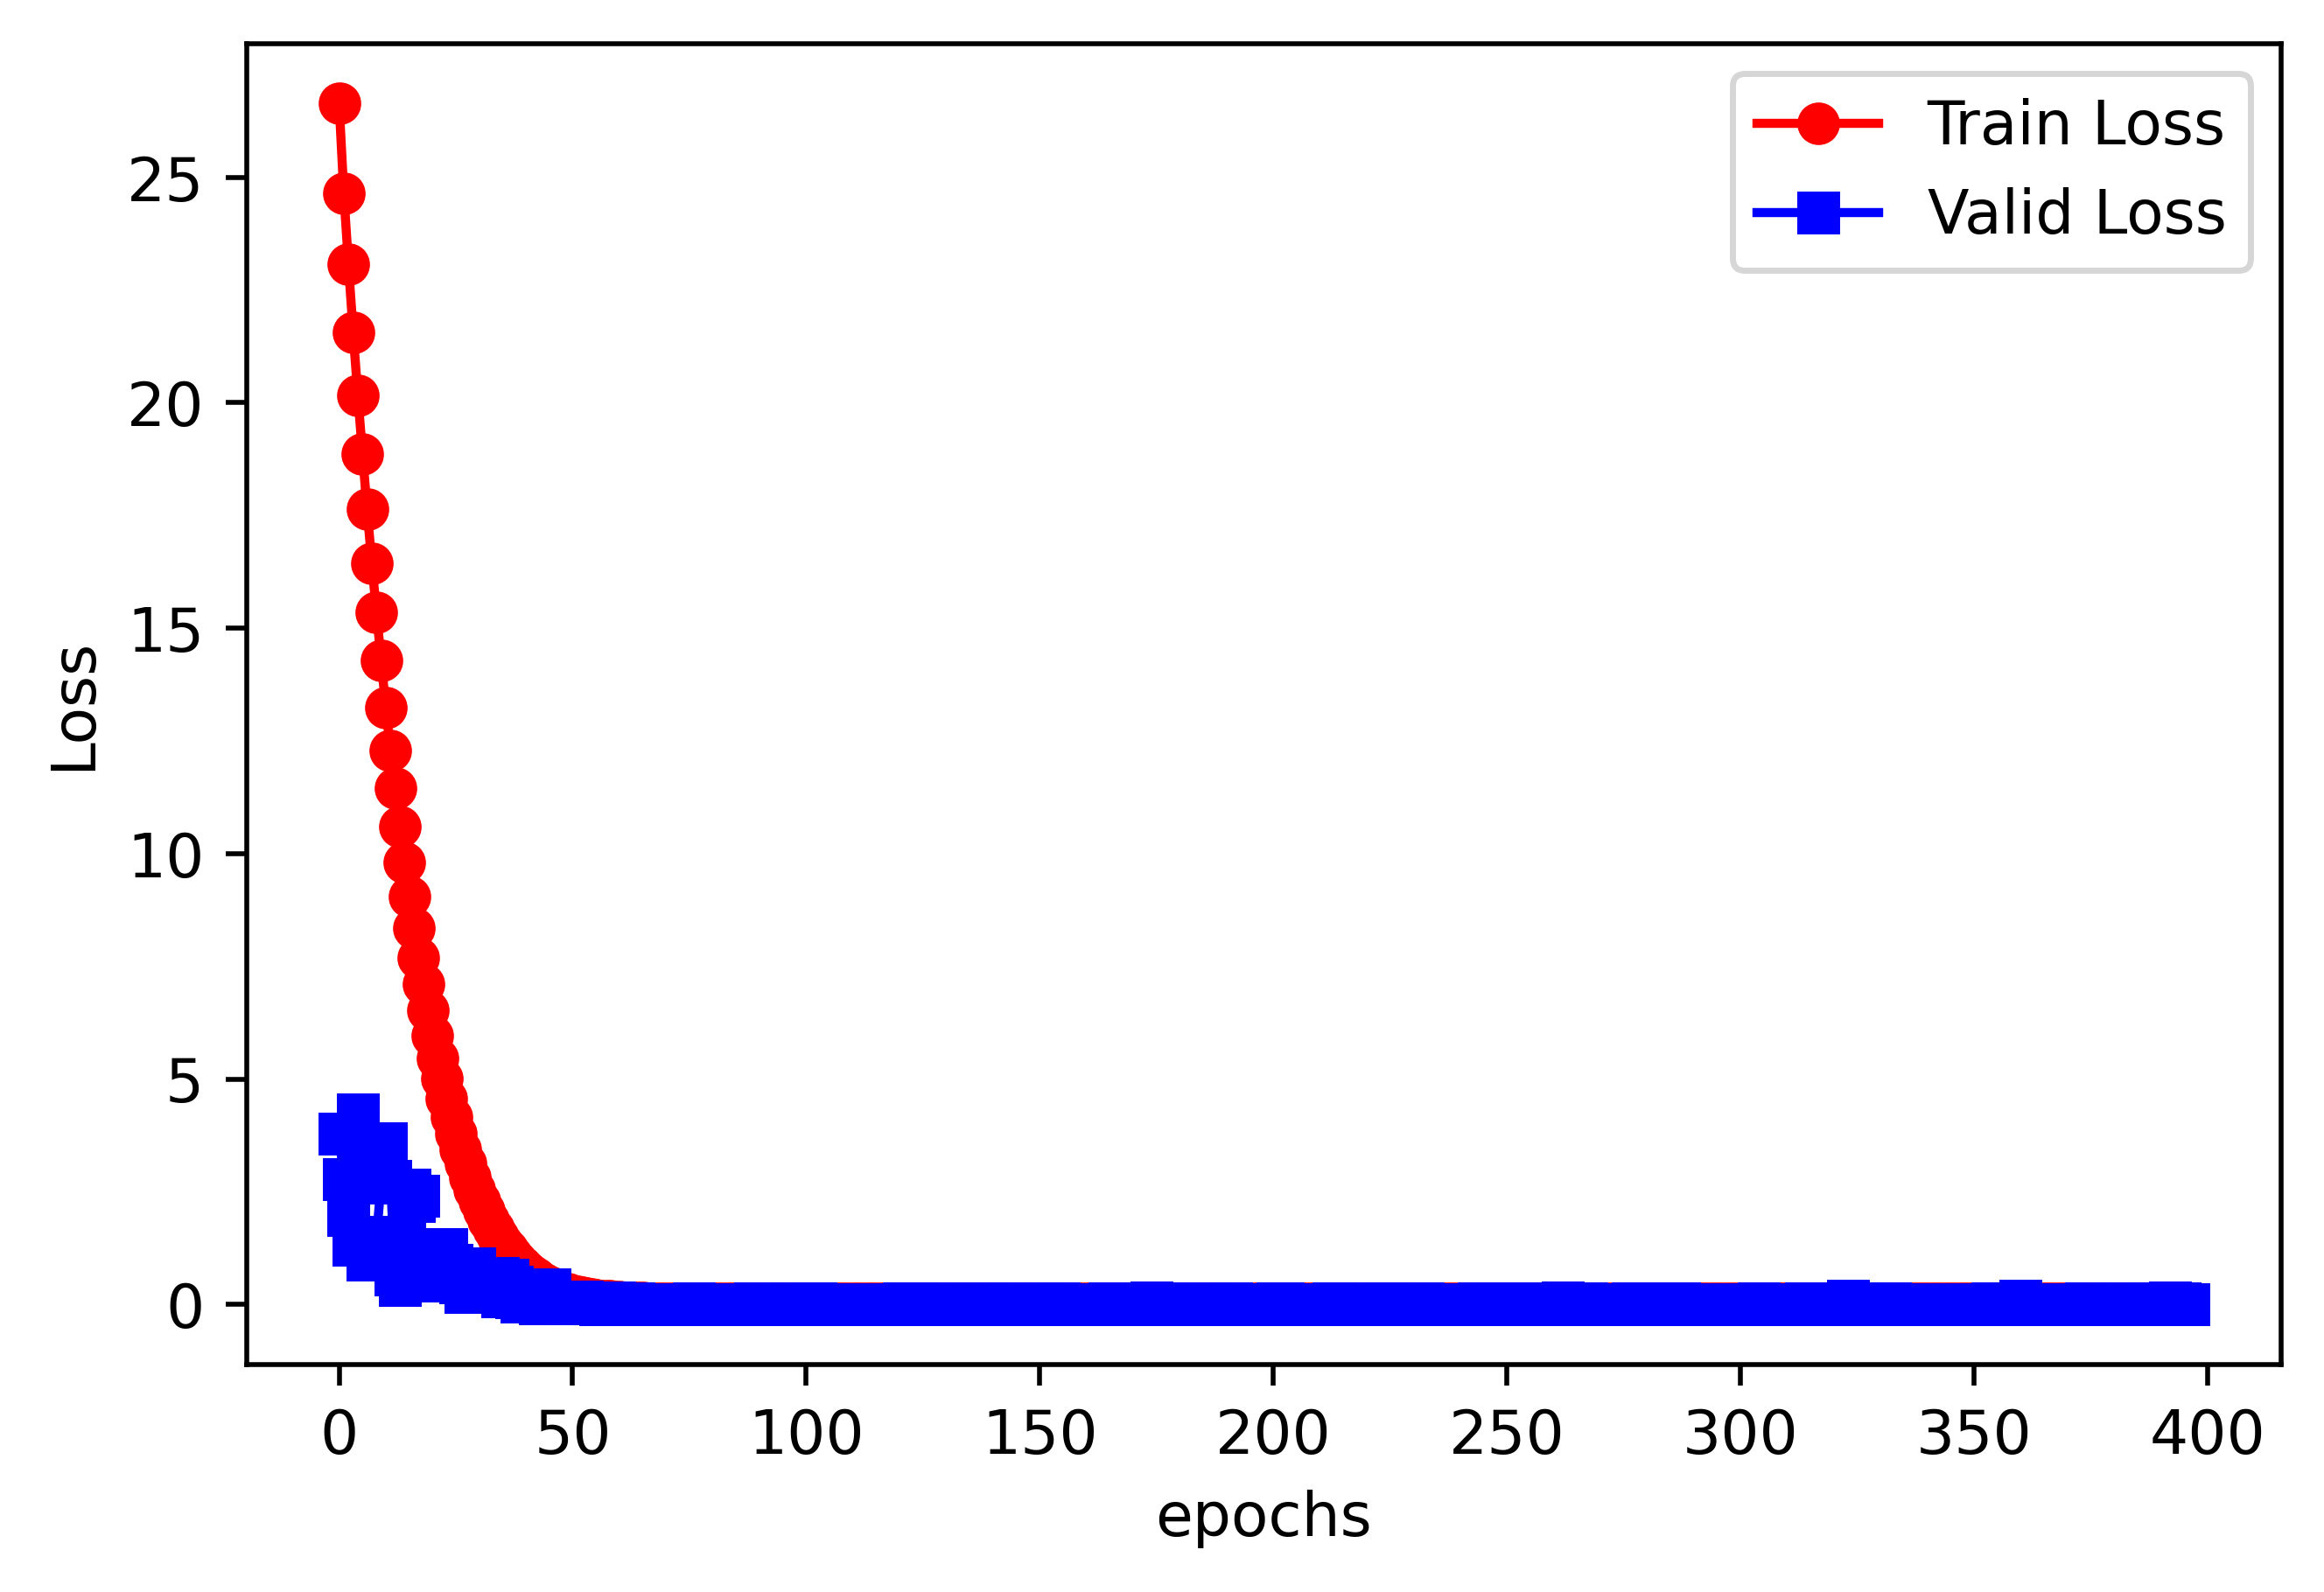

In [9]:
'''
Path of Dataset.
'''
input_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/rain"
label_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/norain"
valid_input_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/rain/X2'
valid_label_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/norain'

'''
Check the device.
'''
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

'''
Move the Network to the CUDA.
'''
net = DDNet().to(device)

'''
Hyper Parameters.
    TODO: fine-tuning.
'''
learning_rate = 1e-3
batch_size = 64
epoch = 500
patience = 200
stale = 0
best_valid_loss = 10000
break_point = 0

'''
Prepare for plt.
'''
Loss_list = []
Valid_Loss_list = []

'''
Define optimizer and Loss Function.
'''
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_f = nn.MSELoss()

'''
Check the model.
'''
if os.path.exists('./model.pth'): 
    print('Continue train with last model...')
    net.load_state_dict(torch.load('./model.pth'))
else: 
    print("Restart...")

'''
Prepare DataLoaders.

Attension:
    'pin_numbers=True' can accelorate CUDA computing.
'''
dataset_train = MyTrainDataset(input_path, label_path)
dataset_valid = MyValidDataset(valid_input_path, valid_label_path)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)

'''
START Training ...
'''
for i in range(epoch):
# ---------------Train----------------
    net.train()
    train_losses = []
    
    '''
    tqdm is a toolkit for progress bar.
    '''
    for batch in tqdm(train_loader):
        inputs, inputs_h, labels = batch
        
        outputs = net(inputs.to(device), inputs_h.to(device))
        loss = loss_f(outputs, labels.to(device))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        '''
        Avoid grad to be too BIG.
        '''
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        
        optimizer.step()
        
        '''
        Attension:
            We need set 'loss.item()' to turn Tensor into Numpy, or plt will not work.
        '''
        train_losses.append(loss.item())
        
    train_loss = sum(train_losses)
    Loss_list.append(train_loss)
    print(f"[ Train | {i + 1:03d}/{epoch:03d} ] loss = {train_loss:.5f}")
    
# -------------Validation-------------
    '''
    Validation is a step to ensure training process is working.
    You can also exploit Validation to see if your net work is overfitting.
    
    Firstly, you should set model.eval(), to ensure parameters not training.
    '''
    net.eval()
    valid_losses = []
    for batch in tqdm(valid_loader):
        inputs, inputs_h, labels = batch
        
        '''
        Cancel gradient decent.
        '''
        with torch.no_grad():
            outputs = net(inputs.to(device), inputs_h.to(device))
        loss = loss_f(outputs, labels.to(device))
        
        valid_losses.append(loss.item())
    
    valid_loss = sum(valid_losses)
    Valid_Loss_list.append(valid_loss)
    print(f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f}")
    
    break_point = i + 1
    
    '''
    Update Logs and save the best model.
    Patience is also checked.
        
    '''
    if valid_loss < best_valid_loss:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f} -> best")
    else:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f}")
    
    if valid_loss < best_valid_loss:
        print(f'Best model found at epoch {i+1}, saving model')
        torch.save(net.state_dict(), f'model_best.ckpt')
        best_valid_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvement {patience} consecutive epochs, early stopping.')
            break

'''
Use plt to draw Loss curves.
'''
plt.figure(dpi=500)
x = range(break_point)
y = Loss_list
plt.plot(x, y, 'ro-', label='Train Loss')
plt.plot(range(break_point), Valid_Loss_list, 'bs-', label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()
        